## Introduction

In this project, we aim to work on given dataset of COMPAS dataset, published by ProPublica. The goal is that we tried to make the prediction fair since we gonna work with some sensitive data such as Race.

## Load the dataset

In [1]:
from __future__ import division
import urllib
import os,sys
import numpy as np
import pandas as pd

from sklearn import feature_extraction
from sklearn import preprocessing
from random import seed, shuffle

from collections import defaultdict
#import utils as ut

SEED = 1234
seed(SEED)
np.random.seed(SEED)

def check_data_file(fname):
    files = os.listdir(".") # get the current directory listing
    print("Looking for file in the current directory...")

    if fname not in files:
        print(" file not found! Downloading from GitHub...")
        addr = "https://raw.githubusercontent.com/propublica/compas-analysis/master/compas-scores-two-years.csv"
        response = urllib.request.urlopen(addr)
        data = response.read()
        fileOut = open(fname, "wb")
        fileOut.write(data)
        fileOut.close()
        print("download and saved locally..")
    else:
        print("File found in current directory..")
    
COMPAS_INPUT_FILE = "compas-scores-two-years.csv"
check_data_file(COMPAS_INPUT_FILE)  


#read file using panda and drop out the missing val

'''
If the charge date of a defendants Compas scored crime was not within 30 days from when the person was arrested, 
assume that because of data quality reasons, that we do not have the right offense.
    
the recidivist flag -- is_recid -- to be -1 if not find a compas case at all.
    
In a similar vein, ordinary traffic offenses -- those with a df of 'O' -- will not result in Jail time are removed.

filtered the underlying data from Broward county to include only those rows representing people who had either
recidivated in two years, or had at least two years outside of a correctional facility.

remove rows where there is no score_text ('N/A')

'''


df = pd.read_csv(COMPAS_INPUT_FILE)
print("Original Entries in dataset")
print(df.shape)

df = df.dropna(subset=["days_b_screening_arrest"]) # dropping missing vals
df = df[(df.days_b_screening_arrest <= 30) & (df.days_b_screening_arrest >= -30) & (df.is_recid != -1) & (df.c_charge_degree != 'O') & (df.score_text != 'N/A') ]
df.reset_index(inplace=True, drop=True) # renumber the rows from 0 again

print("Valid Entries in dataset")
print(df.shape)
#print(df) #2x2 vector

Looking for file in the current directory...
File found in current directory..
Original Entries in dataset
(7214, 53)
Valid Entries in dataset
(6172, 53)


## Dataset Exploration

In [2]:
print("Features in the dataset")
print(df.columns)

print("First 20 rows in dataset")
print(df.head(20))

print("Difference Race in Dataset")
races=set(df.race)
print(races,"\n") 

print("Difference Gender in Dataset")
gender=set(df.sex)
print(gender,"\n")

print("Difference Age in Dataset")
ages=set(df.age)
print(ages,"\n")

print("Number of People by Age")
print(df.groupby('age_cat')['age'].count(),'\n')

print("Number of People by Race")
print(df.groupby('race')['race'].count(),'\n')

print("Number of People by Compas Score")
print(df.groupby('decile_score')['decile_score'].count(),'\n')

print("Number of People by Risk")
print(df.groupby('score_text')['score_text'].count(),'\n')

#by sex and race
print("Sex and Race")
print(pd.crosstab(df['sex'], df['race']),'\n')

#by score and race
print("Decile score and Race")
print(pd.crosstab(df['decile_score'], df['race']),'\n')

#by deferant
print("African-American: %.2f%%" %            (3175 / 6172 * 100))
print("Asian: %.2f%%" %            (31 / 6172 * 100))
print("Caucasian: %.2f%%" %         (2103  / 6172 * 100))
print("Hispanic: %.2f%%" %            (509   / 6172 * 100))
print("Native American: %.2f%%" %  (11   / 6172 * 100))
print("Other: %.2f%%" %  (343   / 6172 * 100),'\n')

#by gender
print(df['sex'].value_counts(),'\n')
print("Men: %.2f%%" %   (4997 / 6172 * 100))
print("Women: %.2f%%" % (1175 / 6172 * 100),'\n')

Features in the dataset
Index(['id', 'name', 'first', 'last', 'compas_screening_date', 'sex', 'dob',
       'age', 'age_cat', 'race', 'juv_fel_count', 'decile_score',
       'juv_misd_count', 'juv_other_count', 'priors_count',
       'days_b_screening_arrest', 'c_jail_in', 'c_jail_out', 'c_case_number',
       'c_offense_date', 'c_arrest_date', 'c_days_from_compas',
       'c_charge_degree', 'c_charge_desc', 'is_recid', 'r_case_number',
       'r_charge_degree', 'r_days_from_arrest', 'r_offense_date',
       'r_charge_desc', 'r_jail_in', 'r_jail_out', 'violent_recid',
       'is_violent_recid', 'vr_case_number', 'vr_charge_degree',
       'vr_offense_date', 'vr_charge_desc', 'type_of_assessment',
       'decile_score.1', 'score_text', 'screening_date',
       'v_type_of_assessment', 'v_decile_score', 'v_score_text',
       'v_screening_date', 'in_custody', 'out_custody', 'priors_count.1',
       'start', 'end', 'event', 'two_year_recid'],
      dtype='object')
First 20 rows in dataset


In [3]:
print("Mean of Decile_score based on Race and Sex")
print(df.groupby(['race','sex'])['decile_score'].mean())

Mean of Decile_score based on Race and Sex
race              sex   
African-American  Female    4.639344
                  Male      5.410129
Asian             Female    2.000000
                  Male      2.896552
Caucasian         Female    3.792531
                  Male      3.588526
Hispanic          Female    2.682927
                  Male      3.517564
Native American   Female    8.500000
                  Male      6.000000
Other             Female    2.741379
                  Male      2.919298
Name: decile_score, dtype: float64


Hist of Decile_score based on Race and Sex


race              sex   
African-American  Female    AxesSubplot(0.125,0.125;0.775x0.755)
                  Male      AxesSubplot(0.125,0.125;0.775x0.755)
Asian             Female    AxesSubplot(0.125,0.125;0.775x0.755)
                  Male      AxesSubplot(0.125,0.125;0.775x0.755)
Caucasian         Female    AxesSubplot(0.125,0.125;0.775x0.755)
                  Male      AxesSubplot(0.125,0.125;0.775x0.755)
Hispanic          Female    AxesSubplot(0.125,0.125;0.775x0.755)
                  Male      AxesSubplot(0.125,0.125;0.775x0.755)
Native American   Female    AxesSubplot(0.125,0.125;0.775x0.755)
                  Male      AxesSubplot(0.125,0.125;0.775x0.755)
Other             Female    AxesSubplot(0.125,0.125;0.775x0.755)
                  Male      AxesSubplot(0.125,0.125;0.775x0.755)
Name: decile_score, dtype: object

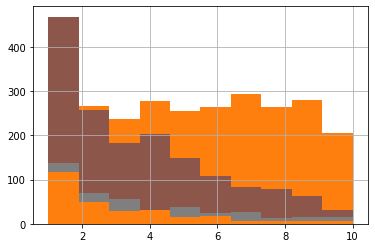

In [4]:
print("Hist of Decile_score based on Race and Sex")
df.groupby(['race','sex'])['decile_score'].hist()

Histogram of decile scores for White


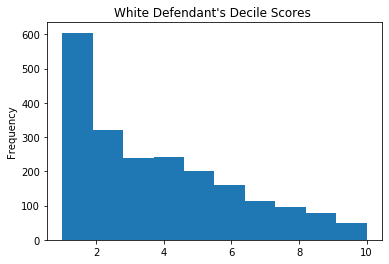

In [5]:
print('Histogram of decile scores for White')
df[df.race == 'Caucasian']['decile_score'].plot(kind='hist', title='White Defendant\'s Decile Scores ')

Histogram of decile scores for Black


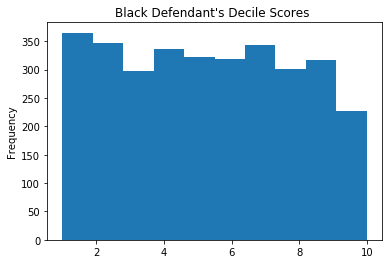

In [6]:
print('Histogram of decile scores for Black')
df[df.race == 'African-American']['decile_score'].plot(kind='hist', title='Black Defendant\'s Decile Scores ')

In [7]:
print("Total People in the dataset")
print(df.shape[0],'\n')

print("People were re-arrested")
print(df['two_year_recid'].sum())
print("%.2f%%" % (df['two_year_recid'].sum()/len(df)*100),'\n')

print("People got re-arrested by age and gender")
print(df.groupby(['race','sex'])['two_year_recid'].sum())

Total People in the dataset
6172 

People were re-arrested
2809
45.51% 

People got re-arrested by age and gender
race              sex   
African-American  Female     203
                  Male      1458
Asian             Female       1
                  Male         7
Caucasian         Female     170
                  Male       652
Hispanic          Female      26
                  Male       163
Native American   Female       2
                  Male         3
Other             Female      11
                  Male       113
Name: two_year_recid, dtype: int64


## Flatten the dataset


In [8]:
FEATURES_CLASS = ["age_cat", "race", "sex", "priors_count", "c_charge_degree"] 
CONTI_FEATURE = ["priors_count"] # continuous features, will need to be handled separately from categorical features, categorical features will be encoded using one-hot
CLASS_FEATURE = "two_year_recid" # the classifier variable
SENSITIVE_FEATURE = "race"

In [9]:
#Convert to NP Array
data = df.to_dict('list')
for k in data.keys():
		data[k] = np.array(data[k])

In [10]:
#Normalize the feature

# convert class label 0 to -1
y = data[CLASS_FEATURE]
y[y==0] = -1


print ("\nNumber of people recidivating within two years")
print (pd.Series(y).value_counts()) #-1 mean were not rearrested
print ("\n")

X = np.array([]).reshape(len(y), 0) # empty array with num rows same as num examples, will hstack the features to it
print(X.shape)
x_control = defaultdict(list)


feature_names = []

for attr in FEATURES_CLASS:
		vals = data[attr]
		if attr in CONTI_FEATURE:
			vals = [float(v) for v in vals]
			vals = preprocessing.scale(vals) # 0 mean and 1 variance  
			vals = np.reshape(vals, (len(y), -1)) # convert from 1-d arr to a 2-d arr with one col

		else: # for binary categorical variables, the label binarizer uses just one var instead of two
			lb = preprocessing.LabelBinarizer()
			lb.fit(vals)
			vals = lb.transform(vals)

		# add to sensitive features dict
		if attr in SENSITIVE_FEATURE:
			x_control[attr] = vals


		# add to learnable features
		X = np.hstack((X, vals))

		if attr in CONTI_FEATURE: # continuous feature, just append the name
			feature_names.append(attr)
		else: # categorical features
			if vals.shape[1] == 1: # binary features that passed through lib binarizer
				feature_names.append(attr)
			else:
				for k in lb.classes_: # non-binary categorical features, need to add the names for each cat
					feature_names.append(attr + "_" + str(k))


# convert the sensitive feature to 1-d array
x_control = dict(x_control)
for k in x_control.keys():
		#assert(x_control[k].shape[1] == 1) # make sure that the sensitive feature is binary after one hot encoding
		x_control[k] = np.array(x_control[k]).flatten()
	
print(x_control)
print(X.shape)
print(y.shape)
print(feature_names)


Number of people recidivating within two years
-1    3363
 1    2809
dtype: int64


(6172, 0)
{'race': array([0, 0, 0, ..., 1, 0, 0])}
(6172, 12)
(6172,)
['age_cat_25 - 45', 'age_cat_Greater than 45', 'age_cat_Less than 25', 'race_African-American', 'race_Asian', 'race_Caucasian', 'race_Hispanic', 'race_Native American', 'race_Other', 'sex', 'priors_count', 'c_charge_degree']


## Standard Classifier

### Define some function

In [11]:
#define helper funcs
def print_ppv_fpv(cm):
    # the indices here are [col][row] or [actual][guessed]
    TN = cm[False][False]   
    TP = cm[True][True]
    FN = cm[True][False]
    FP = cm[False][True]
    print('Accuracy: ', (TN+TP)/(TN+TP+FN+FP))
    print('PPV: ', TP / (TP + FP))
    print('FPR: ', FP / (FP + TN))
    print('FNR: ', FN / (FN + TP))
    print()

def print_metrics(guessed, actual):
    cm = pd.crosstab(guessed, actual, rownames=['guessed'], colnames=['actual'])
    print(cm)
    print()
    print_ppv_fpv(cm)

###Split into Test and Train.


In [12]:
def my_split_into_train_test(x_all, y_all, x_control_all, train_size):

    split_point = int(round(float(x_all.shape[0]) * train_size))
    x_all_train = x_all[:split_point]
    x_all_test = x_all[split_point:]
    y_all_train = y_all[:split_point]
    y_all_test = y_all[split_point:]
    x_control_all_train = {}
    x_control_all_test = {}
    for k in x_control_all.keys():
        x_control_all_train[k] = x_control_all[k][:split_point]
        x_control_all_test[k] = x_control_all[k][split_point:]

    return x_all_train, y_all_train, x_control_all_train, x_all_test, y_all_test, x_control_all_test

In [13]:
def my_split (x_all,y_all,train_size):
  split_point = int(round(float(x_all.shape[0]) * train_size))
  x_all_train = x_all[:split_point]
  x_all_test = x_all[split_point:]
  y_all_train = y_all[:split_point]
  y_all_test = y_all[split_point:]

  return x_all_train, y_all_train, x_all_test, y_all_test

In [14]:
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score

#x_train, y_train, x_control_train, x_test, y_test, x_control_test = my_split_into_train_test(X, y, x_control, 0.8)
x_train, y_train, x_test, y_test = my_split(X,y,0.2)

### MLP Classification

In [15]:
from sklearn.neural_network import MLPClassifier
mlp_model = MLPClassifier(solver='sgd', alpha=1e-5,hidden_layer_sizes=(5, 2), random_state=1)
mlp_model.fit(x_train,y_train)
mlp_model_y=mlp_model.predict(x_test)
print("Accuracy :",accuracy_score(y_test, mlp_model_y))

Accuracy : 0.612798703928716


/home/tsotne/.local/lib/python3.6/site-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


In [16]:
guessed=pd.Series(mlp_model_y)==1
actual=y_test==1

cm = pd.crosstab(guessed, actual, rownames=['guessed'], colnames=['actual'])
cm

actual,False,True
guessed,,
False,2468,1714
True,198,558


In [17]:
print_ppv_fpv(cm)

Accuracy:  0.612798703928716
PPV:  0.7380952380952381
FPR:  0.07426856714178545
FNR:  0.7544014084507042



### Gussian NB Classification

In [18]:
#GuassianNB 
from sklearn.naive_bayes import GaussianNB
gnb_model=GaussianNB()
gnb_model.fit(x_train,y_train)
gnb_ymodel=gnb_model.predict(x_test)
print("Accuracy :",accuracy_score(y_test, gnb_ymodel))

Accuracy : 0.4631429728635075


In [19]:
guessed=pd.Series(gnb_ymodel)==1
actual=y_test==1

cm = pd.crosstab(guessed, actual, rownames=['guessed'], colnames=['actual'])
cm

actual,False,True
guessed,,
False,30,15
True,2636,2257


In [20]:
print_ppv_fpv(cm)

Accuracy:  0.4631429728635075
PPV:  0.46127120376047415
FPR:  0.9887471867966992
FNR:  0.006602112676056338



### SVM Classification

In [21]:
#SVM classifier
from sklearn import svm
svm_model=svm.SVC()
svm_model.fit(x_train,y_train)
svm_model_y=svm_model.predict(x_test)
print("Accuracy :",accuracy_score(y_test,svm_model_y))

Accuracy : 0.6593762656946132


In [22]:
guessed=pd.Series(svm_model_y)==1
actual=y_test==1

cm = pd.crosstab(guessed, actual, rownames=['guessed'], colnames=['actual'])
cm

actual,False,True
guessed,,
False,1964,980
True,702,1292


In [23]:
print_ppv_fpv(cm)

Accuracy:  0.6593762656946132
PPV:  0.6479438314944834
FPR:  0.2633158289572393
FNR:  0.43133802816901406



### Random Forest Classification

In [24]:
#Random Forest classifier
from sklearn.ensemble import RandomForestClassifier
rf_model=RandomForestClassifier()
rf_model.fit(x_train,y_train)
rf_model_y=rf_model.predict(x_test)
print("Accuracy :",accuracy_score(y_test,rf_model_y))

Accuracy : 0.6423653300931551


In [25]:
guessed=pd.Series(rf_model_y)==1
actual=y_test==1

cm = pd.crosstab(guessed, actual, rownames=['guessed'], colnames=['actual'])
cm

actual,False,True
guessed,,
False,1895,995
True,771,1277


In [26]:
print_ppv_fpv(cm)

Accuracy:  0.6423653300931551
PPV:  0.62353515625
FPR:  0.2891972993248312
FNR:  0.43794014084507044



### ROC and AUC plot

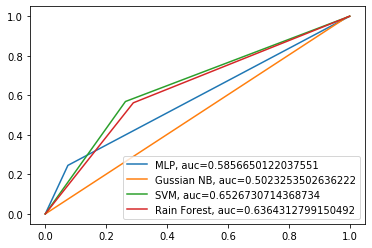

In [27]:

from sklearn import metrics
import matplotlib.pyplot as plt


mlp_fpr, mlp_tpr, _ = metrics.roc_curve(y_test,mlp_model_y)
mlp_auc = metrics.roc_auc_score(y_test,mlp_model_y)
plt.plot(mlp_fpr,mlp_tpr,label="MLP, auc="+str(mlp_auc))

gnb_fpr, gnb_tpr, _ = metrics.roc_curve(y_test,gnb_ymodel)
gnb_auc = metrics.roc_auc_score(y_test, gnb_ymodel)
plt.plot(gnb_fpr,gnb_tpr,label="Gussian NB, auc="+str(gnb_auc))

svm_fpr, svm_tpr, _ = metrics.roc_curve(y_test,svm_model_y)
svm_auc = metrics.roc_auc_score(y_test, svm_model_y)
plt.plot(svm_fpr,svm_tpr,label="SVM, auc="+str(svm_auc))

rf_fpr, rf_tpr, _ = metrics.roc_curve(y_test,rf_model_y)
rf_auc = metrics.roc_auc_score(y_test, rf_model_y)
plt.plot(rf_fpr,rf_tpr,label="Rain Forest, auc="+str(rf_auc))


plt.legend(loc=4)
plt.show()


## Fairness Classifier : Racial Bias
there is a significant difference in Compas scores between races or not?!

To check this we need to change some variables into factors, and run a logistic regression, comparing low scores to high scores.



In [28]:
from sklearn.linear_model import LogisticRegression
lr = LogisticRegression(solver='lbfgs')

#Convert categorical variable into dummy/indicator variables.
#Get dataframes

df_crime = pd.get_dummies(df['c_charge_degree'],prefix='crimefactor',drop_first=True)
df_age = pd.get_dummies(df['age_cat'],prefix='age')
df_race = pd.get_dummies(df['race'],prefix='race')
df_gender = pd.get_dummies(df['sex'],prefix='sex',drop_first=True)
df_score = pd.get_dummies(df['score_text'] != 'Low',prefix='score_factor',drop_first=True)

#Concatenate pandas objects along a particular axis with optional set logic along the other axes.
#axis=1 in our case, we use column, instead of index
df_lr = pd.concat([df_crime, df_age,df_race,df_gender,df['priors_count'],df['two_year_recid']],axis=1)

In [29]:
lr.fit(df_lr,df_score.values.ravel())

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [30]:
cols = np.concatenate([df_crime.columns.values, 
                df_age.columns.values,
                df_race.columns.values,
                df_gender.columns.values,
                ['priors_count'],
                ['two_year_recid']
               ])

#Interpreting the Intercept in a Regression
print('%.3f' % lr.intercept_, '(Intercept)') 
for i,j in zip(cols, lr.coef_[0]): print('%.3f' % j, i)

-1.335 (Intercept)
-0.310 crimefactor_M
0.018 age_25 - 45
-1.328 age_Greater than 45
1.319 age_Less than 25
0.490 race_African-American
-0.201 race_Asian
0.013 race_Caucasian
-0.409 race_Hispanic
0.909 race_Native American
-0.793 race_Other
-0.219 sex_Male
0.268 priors_count
0.683 two_year_recid


Black defendants are 44% more likely than white defendants to receive a higher score correcting for the seriousness of their crime, previous arrests, and future criminal behavior.


In [31]:
control = np.exp(-1.335) / (1 + np.exp(-1.335))
black= np.exp(0.490) / (1 - control + (control * np.exp(0.490)))
print('Black defendants: %.4f' % black)

Black defendants: 1.4423


Let's look at the proportion of people who are re-arrested in each decile score.

probability of recidivism by decile


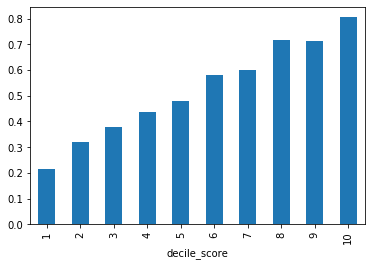

In [32]:
print('probability of recidivism by decile')
df.groupby('decile_score').mean()['two_year_recid'].plot(kind='bar')

probability of recidivism by decile and race


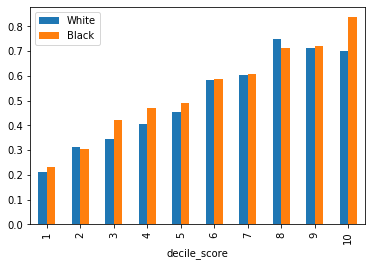

In [33]:
print('probability of recidivism by decile and race')
b = df[df.race=='African-American'].groupby(['decile_score']).mean()['two_year_recid']
w = df[df.race=='Caucasian'].groupby(['decile_score']).mean()['two_year_recid']

a = pd.concat([w,b], axis=1)
a.columns = ['White','Black']
a.plot.bar()

Using this binary prediction variable lets us compute a confusion matrix for the COMPAS algorithm.

In [34]:
print('COMPAS recidivism confusion matrix')
df['guessed_recid'] = df['score_text'] != 'Low'
df['actual_recid'] = df.two_year_recid == 1
cm = pd.crosstab(df.actual_recid, df.guessed_recid)
cm # for "confusion matrix"

COMPAS recidivism confusion matrix


guessed_recid,False,True
actual_recid,,
False,2345,1018
True,1076,1733


In [35]:
# The usual definitions. First index is predicted, second is actual
TN = cm[False][False]
TP = cm[True][True]
FN = cm[False][True]
FP = cm[True][False]

In [36]:
print('PPV - positive predictive value') # getting arrested again within two years
TP / (TP + FP)

PPV - positive predictive value


0.6299527444565612

In [37]:
print('FPR - false positive rate') #those who did not go on to be re-arrested
FP / (FP + TN)

FPR - false positive rate


0.30270591733571217

In [38]:
print('total number of true positive and negative cases')
P = TP + FN
N = TN + FP

print(P)
print(N)

total number of true positive and negative cases
2809
3363


In [39]:
FP / N #FPR

0.30270591733571217

False Negative Rate (FNR) - counts those who were classified as low risk, as a fraction of those who were re-arrested.

In [40]:
print('FNR')
FN / (FN + TP)

FNR


0.38305446778212887

In [41]:
print('White')
subset = df[df.race == 'Caucasian']
print_metrics(subset.guessed_recid, subset.actual_recid)

print('Black')
subset = df[df.race == 'African-American']
print_metrics(subset.guessed_recid, subset.actual_recid)


White
actual   False  True 
guessed              
False      999    408
True       282    414

Accuracy:  0.6718972895863052
PPV:  0.5948275862068966
FPR:  0.22014051522248243
FNR:  0.49635036496350365

Black
actual   False  True 
guessed              
False      873    473
True       641   1188

Accuracy:  0.6491338582677165
PPV:  0.6495352651722253
FPR:  0.4233817701453104
FNR:  0.2847682119205298



the **False Positive Rate** is substantially higher for black defendant

##Our predictor using Logistic regression

We gonna use:
* Age
* Sex
* Felony or Misdemeanor charge (c_charge_degree)
* Number of prior arrests (c_priors_count)

And we'll try this both with and without race as a predictive factor, too.

In [42]:
# build up dummy variables for age, race, gender
features = pd.concat(
    [pd.get_dummies(df.age_cat, prefix='age'),
     pd.get_dummies(df.sex, prefix='sex'),
     pd.get_dummies(df.c_charge_degree, prefix='degree'), # felony or misdemeanor charge ('f' or 'm')
     df.priors_count],
    axis=1)

# We should have one less dummy variable than the number of categories
features.drop(['age_25 - 45', 'sex_Female', 'degree_M'], axis=1, inplace=True)

# Try to predict whether someone is re-arrested
target = df.two_year_recid

In [43]:
x = features.values
y = target.values
lr = LogisticRegression()
lr.fit(x,y)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [44]:
print('Examine regression coefficients')
coeffs = pd.DataFrame(np.exp(lr.coef_), columns=features.columns)
coeffs

Examine regression coefficients


,age_Greater than 45,age_Less than 25,sex_Male,degree_F,priors_count
0,0.505402,2.10855,1.403791,1.253803,1.185499


The model thinks that:
* being young (<25) more than doubles your odds of recidivism
* but being >45 years old makes half as likely
* being male increases your odds by 40%
* every prior arrest increases your odds by 18%

Check our model through the same tests as we used on the COMPAS score to see how well this predictor does.

In [45]:
# Crosstab for our predictive model
y_pred = lr.predict(x)
guessed=pd.Series(y_pred)==1

actual=df.two_year_recid==1

cm = pd.crosstab(guessed, actual, rownames=['guessed'], colnames=['actual'])
cm

actual,False,True
guessed,,
False,2568,1239
True,795,1570


In [46]:
print_ppv_fpv(cm)

Accuracy:  0.670447180816591
PPV:  0.6638477801268499
FPR:  0.23639607493309545
FNR:  0.4410822356710573



In [47]:
print('White')
subset = df.race == 'Caucasian'
print_metrics(guessed[subset], actual[subset])

print('Black')
subset = df.race == 'African-American'
print_metrics(guessed[subset], actual[subset])

White
actual   False  True 
guessed              
False     1068    494
True       213    328

Accuracy:  0.6638135996195911
PPV:  0.6062846580406654
FPR:  0.16627634660421545
FNR:  0.6009732360097324

Black
actual   False  True 
guessed              
False     1026    564
True       488   1097

Accuracy:  0.6686614173228347
PPV:  0.6921135646687697
FPR:  0.32232496697490093
FNR:  0.3395544852498495



Better results, but still twice FPR for blacks than whites.

Now, we will try to equalize the **false positive rates** between white and non-white defendants.

We're going to use **race** to set a different threshold for both defendants (blacks, whites).

In [48]:
def predict_thresh_grp(clf, ft, a_thresh, b_thresh, use_b):
    # calculate probabilities from our classifier
    proba = clf.predict_proba(ft)[:,1]
    
    # Create one Series which is True where the probabilities are bigger than a_thres, 
    # and another for b_thresh
    # Then combine them, selecting values from either Series according to use_b
    guess = pd.Series(proba > a_thresh)
    guess.loc[use_b] = pd.Series(proba > b_thresh)
    return guess

Tried different threshold to get result:

In [49]:
guessed = predict_thresh_grp(lr, x, 0.495, 0.57, df.race=='African-American')

print('Everyone')
print_metrics(guessed, actual)

print('White')
subset = df.race == 'Caucasian'
print_metrics(guessed[subset], actual[subset])

print('Black')
subset = df.race == 'African-American'
print_metrics(guessed[subset], actual[subset])

Everyone
actual   False  True 
guessed              
False     2775   1538
True       588   1271

Accuracy:  0.6555411535968891
PPV:  0.6837009144701452
FPR:  0.17484388938447815
FNR:  0.5475258098967604

White
actual   False  True 
guessed              
False     1061    493
True       220    329

Accuracy:  0.6609605325725154
PPV:  0.599271402550091
FPR:  0.1717408274785324
FNR:  0.5997566909975669

Black
actual   False  True 
guessed              
False     1243    864
True       271    797

Accuracy:  0.6425196850393701
PPV:  0.7462546816479401
FPR:  0.17899603698811095
FNR:  0.5201685731487056



In this case we raised the threshold for blacks from **0.5 to 0.7**, and reduced threshold from **0.5 to 0.495** for whites, which equalizes the FPR at about **17%**. 

The overall accuracy fell only slightly from **67%** to **65%**, and the accuracy for blacks fell from **66%** to **64%**, for whites it's same **66%**. 

But the PPV for blacks, the probability that someone who is categorized as high risk will actually be re-arrested within two years, increased from **69%** to **74%**, because the higher threshold removes some of the people who were not particularly risky from the high risk group. The cost is a higher false negative rate for blacks, which changed from **33%** to **52%**.
